<a href="https://colab.research.google.com/github/Lokuhu/112-2_2LNN/blob/main/%E5%9B%9BD56_HW5_r_EB_cram_pruning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
# 試算表>檔案>共用>發布到網路 即可於colab中讀取
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQhbAejyGUXlZltX2nsbC4sTw890L6081piAP8ZDJVbufqZ9xm-S5P7gIrXnpgszm-U9SmEkBxJc5uF/pub?gid=1265524659&single=true&output=csv'
seed = pd.read_csv(url)

In [ ]:
seed['Type'] = seed['Type'].replace(1, 0.0)
seed['Type'] = seed['Type'].replace(2, 1.0)
seed['Type'] = seed['Type'].replace(3, 2.0)
seed

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,2
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,2
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,2
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,2


In [ ]:
# Split data
X = seed.drop('Type',axis=1)
y = seed['Type']

# Covert these to numpy arr
X = X.values
y = y.values

# 20%test, 80%training
X_train, X_test, y_train, y_test=train_test_split (X, y ,test_size = 0.2, random_state = 30)

# Covert X and y to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
# definition model
class Model5(nn.Module):
    def __init__(self, in_features=7, h1=11, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(p=0.5)  # 添加 Dropout

        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)  # 在激活函數之後和輸出層之前添加 Dropout
        x = torch.tanh(self.out(x))
        return x

In [ ]:
# 修剪隱藏節點！
def prune_hidden_nodes(model, threshold=0.01):
    mask = model.fc1.weight.abs().sum(dim=1) > threshold
    mask = mask.nonzero().squeeze()

    # 新模型的隱藏節點的數目 = 未被修剪的節點數
    new_h1 = mask.size(0)
    new_model = Model5(in_features=7, h1=new_h1, out_features=3)

    # 複製權重到新模型
    with torch.no_grad():
        new_model.fc1.weight = nn.Parameter(model.fc1.weight[mask])
        new_model.fc1.bias = nn.Parameter(model.fc1.bias[mask])
        new_model.out.weight = nn.Parameter(model.out.weight[:, mask])
        new_model.out.bias = model.out.bias

    return new_model

# Cramming module: 加上新的hidden nodes，調整權重
def cramming(model, X_train, y_train):
    criterion = nn.CrossEntropyLoss() #定義loss function
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)

    # 找出所有分類錯誤的樣本的index
    incorrect_indices = (y_pred.argmax(dim=1) != y_train).nonzero(as_tuple=True)[0]
    #print("Incorrect indices:", incorrect_indices)

    if len(incorrect_indices) == 0:
        return model

    for i in incorrect_indices:
        new_h1 = model.fc1.weight.size(0) + 3
        new_model = Model5(in_features=7, h1=new_h1, out_features=3)

        with torch.no_grad():
            new_model.fc1.weight[:-3] = model.fc1.weight
            new_model.fc1.bias[:-3] = model.fc1.bias

            new_model.fc1.weight[-3] = X_train[i]
            new_model.fc1.weight[-2] = X_train[i] * 0.5  # Example transformation
            new_model.fc1.weight[-1] = X_train[i] * -0.5

            new_model.fc1.bias[-3] = 1 - X_train[i].sum()
            new_model.fc1.bias[-2] = 1 - (X_train[i] * 0.5).sum()
            new_model.fc1.bias[-1] = 1 - (X_train[i] * -0.5).sum()

            #print(f"對 misclassified index {i} 加入三個隱藏節點")

            new_model.out.weight[:, :-3] = model.out.weight
            new_model.out.weight[:, -3:] = 0.0
            new_model.out.bias = model.out.bias

        model = new_model
    return model




In [ ]:
# 訓練模型的函數EB
def train_model(model, X_train, y_train, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} Loss: {loss.item()}')

        loss.backward()
        optimizer.step()

    return model, losses

In [ ]:
# 初始模型訓練
torch.manual_seed(41)
model5 = Model5()
model5, losses = train_model(model5, X_train, y_train, epochs=100, lr=0.005)
# 先150次EB初步訓練後再來修剪（另外的150次）=>減少模型複雜度

Epoch: 0 Loss: 1.1781643629074097
Epoch: 10 Loss: 1.1823440790176392
Epoch: 20 Loss: 1.216480016708374
Epoch: 30 Loss: 1.129953384399414
Epoch: 40 Loss: 1.1692026853561401
Epoch: 50 Loss: 1.1267244815826416
Epoch: 60 Loss: 1.1705942153930664
Epoch: 70 Loss: 1.1458479166030884
Epoch: 80 Loss: 1.173075795173645
Epoch: 90 Loss: 1.1506116390228271


In [ ]:
# 修剪irrelevant的隱藏節點
model5 = prune_hidden_nodes(model5, threshold=0.01)
model5 = cramming(model5, X_train, y_train)


In [ ]:
# 繼續訓練修剪後的模型
model5, more_losses = train_model(model5, X_train, y_train, epochs=100, lr=0.005)

Epoch: 0 Loss: 1.1026966571807861
Epoch: 10 Loss: 1.1323683261871338
Epoch: 20 Loss: 1.17298424243927
Epoch: 30 Loss: 1.153102159500122
Epoch: 40 Loss: 1.1248884201049805
Epoch: 50 Loss: 1.1101430654525757
Epoch: 60 Loss: 1.095536470413208
Epoch: 70 Loss: 1.1340630054473877
Epoch: 80 Loss: 1.132838249206543
Epoch: 90 Loss: 1.1226712465286255


In [ ]:
# 合併損失
#losses.extend(more_losses)

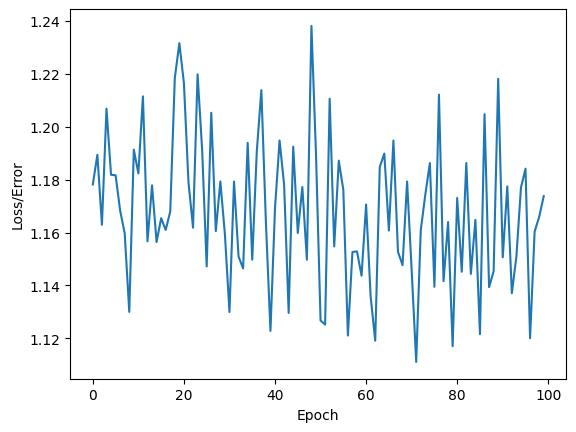

Validation Loss is: 1.1124415397644043
Accuracy is: 0.2619047619047619


In [ ]:
# 畫圖
plt.plot(range(len(losses)), losses)
plt.ylabel('Loss/Error')
plt.xlabel('Epoch')
plt.show()

# 重新定義全局範圍內的 criterion？
criterion = nn.CrossEntropyLoss()

# 評估模型
with torch.no_grad():
    y_eval = model5(X_test)
    loss = criterion(y_eval, y_test)
    correct = (y_eval.argmax(dim=1) == y_test).sum().item()

print(f'Validation Loss is: {loss.item()}')
print(f'Accuracy is: {correct / len(y_test)}')